In [254]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Machine learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Pipeline
from sklearn.pipeline import Pipeline

# Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [255]:
user_profiles = pd.read_csv(r'data/user_profiles_with_diverse_clusters.csv')
user_profiles.head()

,user_id,age,gender,height_cm,weight_kg,BMI,activity_level,blood_pressure,cholesterol_level,calorie_intake,cluster,diet_recommendation
0,1,68,Female,142,60,28.7,Sedentary,129/85,Normal,1623,2,Plant-Based
1,2,55,Female,145,50,23.6,Sedentary,117/73,Borderline,1601,1,Mediterranean
2,3,75,Male,174,51,17.2,Sedentary,106/80,Borderline,2775,5,Balanced
3,4,22,Male,170,58,20.8,Lightly Active,111/77,Normal,1668,3,Ketogenic
4,5,29,Male,176,83,26.6,Moderately Active,120/83,Normal,1663,4,High-Protein


In [256]:
# user_profiles.drop("user_id", axis=1, inplace=True)

In [257]:
# user_profiles['height_cm'] = user_profiles['height_cm'].fillna(user_profiles['height_cm'].median())

# user_profiles['weight_kg'] = user_profiles['weight_kg'].fillna(user_profiles['weight_kg'].median())


# user_profiles = user_profiles.dropna(subset=['diet_recommendation'])
# user_profiles['blood_pressure'] = user_profiles["blood_pressure"].fillna(user_profiles["blood_pressure"].mode()[0])

# user_profiles['age'] = user_profiles["age"].fillna(user_profiles["age"].mode()[0])

# user_profiles['allergy_status'] = user_profiles['allergy_status'].fillna('No Allergies')
# user_profiles.isna().sum()

In [258]:
# # Calculate BMI
# user_profiles['BMI'] = (user_profiles['weight_kg'] / ((user_profiles['height_cm'] / 100) ** 2)).round(1)

# Drop height_cm and weight_kg columns
user_profiles = user_profiles.drop(['height_cm', 'weight_kg'], axis=1)

# # Checking the first few rows to confirm changes
# user_profiles.head()

In [259]:
# Split the blood_pressure column into systolic and diastolic values
user_profiles[['systolic', 'diastolic']] = user_profiles['blood_pressure'].str.split('/', expand=True).astype(float)

# Fill missing systolic and diastolic values with median if any
user_profiles['systolic'].fillna(user_profiles['systolic'].median(), inplace=True)
user_profiles['diastolic'].fillna(user_profiles['diastolic'].median(), inplace=True)

# Categorize blood pressure based on systolic and diastolic values
def categorize_blood_pressure(row):
    if row['systolic'] < 120 and row['diastolic'] < 80:
        return 'Normal'
    elif 120 <= row['systolic'] < 130 and row['diastolic'] < 80:
        return 'Elevated'
    elif 130 <= row['systolic'] < 140 or 80 <= row['diastolic'] < 90:
        return 'Hypertension Stage 1'
    elif row['systolic'] >= 140 or row['diastolic'] >= 90:
        return 'Hypertension Stage 2'
    elif row['systolic'] > 180 or row['diastolic'] > 120:
        return 'Hypertensive Crisis'
    else:
        return 'Unknown'

# Apply categorization function to create a new 'blood_pressure_category' column
user_profiles['blood_pressure_category'] = user_profiles.apply(categorize_blood_pressure, axis=1)

# Drop the original blood_pressure column
user_profiles.drop(columns=["user_id", 'blood_pressure', "systolic", "diastolic", "cluster"], inplace=True)

# View the updated dataframe
user_profiles.head()


/tmp/ipykernel_7762/2565103081.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  user_profiles['systolic'].fillna(user_profiles['systolic'].median(), inplace=True)
/tmp/ipykernel_7762/2565103081.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].

,age,gender,BMI,activity_level,cholesterol_level,calorie_intake,diet_recommendation,blood_pressure_category
0,68,Female,28.7,Sedentary,Normal,1623,Plant-Based,Hypertension Stage 1
1,55,Female,23.6,Sedentary,Borderline,1601,Mediterranean,Normal
2,75,Male,17.2,Sedentary,Borderline,2775,Balanced,Hypertension Stage 1
3,22,Male,20.8,Lightly Active,Normal,1668,Ketogenic,Normal
4,29,Male,26.6,Moderately Active,Normal,1663,High-Protein,Hypertension Stage 1


In [260]:
x = user_profiles.drop("diet_recommendation", axis=1)
x.head()

,age,gender,BMI,activity_level,cholesterol_level,calorie_intake,blood_pressure_category
0,68,Female,28.7,Sedentary,Normal,1623,Hypertension Stage 1
1,55,Female,23.6,Sedentary,Borderline,1601,Normal
2,75,Male,17.2,Sedentary,Borderline,2775,Hypertension Stage 1
3,22,Male,20.8,Lightly Active,Normal,1668,Normal
4,29,Male,26.6,Moderately Active,Normal,1663,Hypertension Stage 1


In [261]:
y = user_profiles["diet_recommendation"]
y.head()

0      Plant-Based
1    Mediterranean
2         Balanced
3        Ketogenic
4     High-Protein
Name: diet_recommendation, dtype: object

In [262]:
# creating column transformer with 2 types of transformers

numeric_features = x.select_dtypes(exclude="object").columns
categorical_features = x.select_dtypes(include="object").columns


numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, categorical_features),
        ("StandardScaler", numeric_transformer, numeric_features),
    ]
)

In [263]:
x = preprocessor.fit_transform(x)

In [264]:
# train test split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_train.shape, x_test.shape

((35000, 16), (15000, 16))

In [265]:
x

array([[ 1.        ,  0.        ,  0.        , ...,  1.61110984,
         0.38375029, -1.32834138],
       [ 1.        ,  0.        ,  0.        , ...,  0.86058889,
        -0.36917021, -1.37809439],
       [ 0.        ,  1.        ,  0.        , ...,  2.0152365 ,
        -1.31401161,  1.27690734],
       ...,
       [ 1.        ,  0.        ,  1.        , ..., -1.10231206,
         0.44280288,  1.22263133],
       [ 0.        ,  1.        ,  0.        , ...,  0.91832127,
         0.69377638, -0.49158615],
       [ 1.        ,  0.        ,  0.        , ...,  0.34099746,
         0.17706623, -0.05511652]])


Training Logistic Regression...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ............................C=0.1, solver=liblinear; total time=   0.4s
[CV] END ............................C=0.1, solver=liblinear; total time=   0.5s
[CV] END ..................................C=1, solver=lbfgs; total time=   0.5s
[CV] END .............................C=10, solver=liblinear; total time=   0.5s
[CV] END .................................C=10, solver=lbfgs; total time=   0.5s
[CV] END ..................................C=1, solver=lbfgs; total time=   0.6s
[CV] END ................................C=0.1, solver=lbfgs; total time=   0.6s
[CV] END ..................................C=1, solver=lbfgs; total time=   0.6s
[CV] END .............................C=10, solver=liblinear; total time=   0.6s
[CV] END .................................C=10, solver=lbfgs; total time=   0.6s
[CV] END ................................C=0.1, solver=lbfgs; total time=   0.6s
[CV] END .......

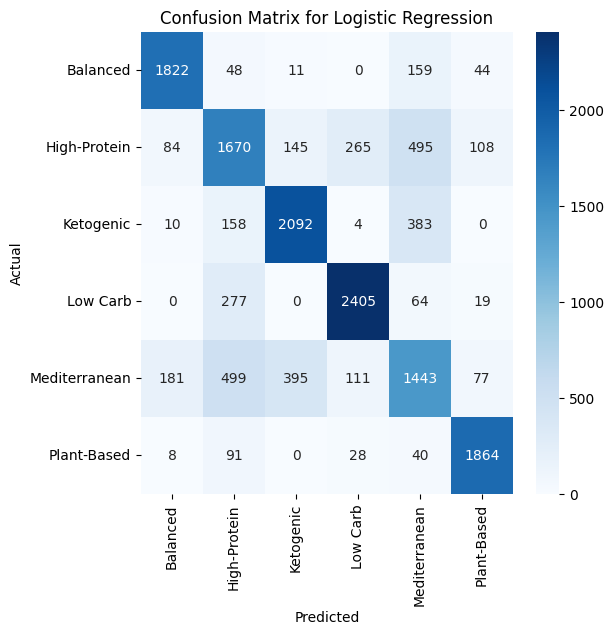


Training Random Forest...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   2.6s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   2.7s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   2.7s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   2.9s
[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=   3.2s
[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=   4.5s
[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=   4.6s
[CV] END max_depth=10, min_samples_split=10, n_estimators=200; total time=   4.9s
[CV] END max_depth=10, min_samples_split=10, n_estimators=200; total time=   5.0s
[CV] END max_dep

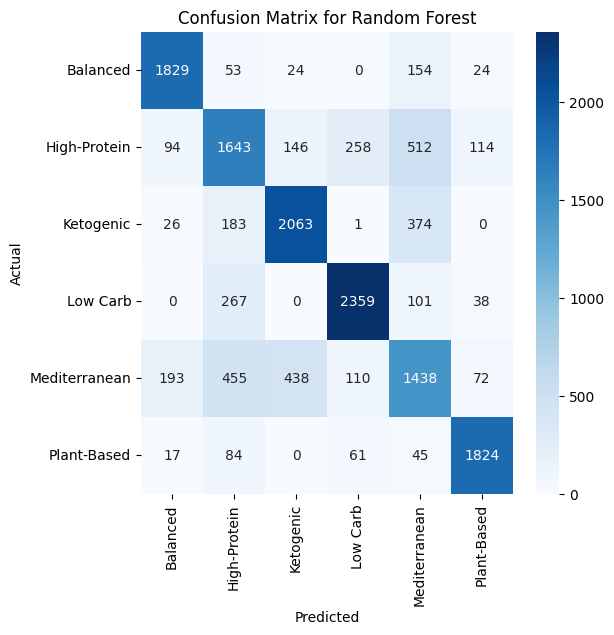


Training Support Vector Classifier...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END .................................C=1, kernel=linear; total time=   9.8s
[CV] END ...............................C=0.1, kernel=linear; total time=  10.4s
[CV] END .................................C=1, kernel=linear; total time=  10.5s
[CV] END ................................C=10, kernel=linear; total time=  16.3s
[CV] END .................................C=1, kernel=linear; total time=  16.3s
[CV] END ...............................C=0.1, kernel=linear; total time=  17.6s
[CV] END ...............................C=0.1, kernel=linear; total time=  18.3s
[CV] END ................................C=10, kernel=linear; total time=  18.3s
[CV] END ................................C=10, kernel=linear; total time=  22.0s
[CV] END ..................................C=0.1, kernel=rbf; total time=  22.1s
[CV] END ....................................C=1, kernel=rbf; total time=  22.5s
[CV] END .

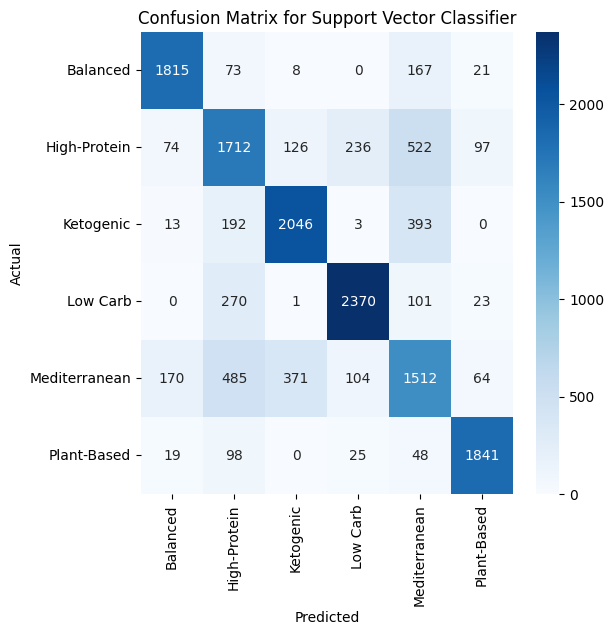


Training K-Nearest Neighbors...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END ..metric=euclidean, n_neighbors=7, weights=distance; total time=   2.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   2.1s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   2.1s
[CV] END ..metric=euclidean, n_neighbors=7, weights=distance; total time=   2.2s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   2.3s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   2.4s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   2.5s
[CV] END ...metric=euclidean, n_neighbors=7, weights=uniform; total time=   2.5s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   2.5s
[CV] END ...metric=manhattan, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ...met

/home/jayasurya/Desktop/diet_recommendation/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/jayasurya/Desktop/diet_recommendation/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jayasurya/Desktop/diet_recommendation/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jayasurya/Desktop/diet_recommendation/.venv/lib/python3.12/site-packages/sklearn/base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                        

[CV] END ...metric=manhattan, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=5, weights=uniform; total time=   0.0s


/home/jayasurya/Desktop/diet_recommendation/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/jayasurya/Desktop/diet_recommendation/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jayasurya/Desktop/diet_recommendation/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jayasurya/Desktop/diet_recommendation/.venv/lib/python3.12/site-packages/sklearn/base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                        

[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   3.0s
[CV] END ..metric=euclidean, n_neighbors=7, weights=distance; total time=   3.1s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   3.1s
[CV] END ...metric=manhattan, n_neighbors=7, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   3.2s


/home/jayasurya/Desktop/diet_recommendation/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/jayasurya/Desktop/diet_recommendation/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jayasurya/Desktop/diet_recommendation/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jayasurya/Desktop/diet_recommendation/.venv/lib/python3.12/site-packages/sklearn/base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                        

[CV] END ...metric=manhattan, n_neighbors=7, weights=uniform; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=7, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   3.2s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   3.3s
[CV] END ...metric=manhattan, n_neighbors=9, weights=uniform; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=9, weights=uniform; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=9, weights=uniform; total time=   0.0s


/home/jayasurya/Desktop/diet_recommendation/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/jayasurya/Desktop/diet_recommendation/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jayasurya/Desktop/diet_recommendation/.venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jayasurya/Desktop/diet_recommendation/.venv/lib/python3.12/site-packages/sklearn/base.py", line 764, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                        

[CV] END ...metric=euclidean, n_neighbors=7, weights=uniform; total time=   3.5s
[CV] END ...metric=euclidean, n_neighbors=7, weights=uniform; total time=   3.6s
[CV] END ..metric=euclidean, n_neighbors=9, weights=distance; total time=   2.0s
[CV] END ...metric=euclidean, n_neighbors=9, weights=uniform; total time=   2.5s
[CV] END ..metric=euclidean, n_neighbors=9, weights=distance; total time=   2.3s
[CV] END ...metric=euclidean, n_neighbors=9, weights=uniform; total time=   2.7s
[CV] END ..metric=euclidean, n_neighbors=9, weights=distance; total time=   2.5s
[CV] END ...metric=euclidean, n_neighbors=9, weights=uniform; total time=   3.3s
[CV] END ..metric=manhattan, n_neighbors=3, weights=distance; total time=   4.9s
[CV] END ..metric=manhattan, n_neighbors=3, weights=distance; total time=   5.3s
[CV] END ..metric=manhattan, n_neighbors=7, weights=distance; total time=   5.0s
[CV] END ..metric=manhattan, n_neighbors=3, weights=distance; total time=   5.8s
[CV] END ..metric=manhattan,

/home/jayasurya/Desktop/diet_recommendation/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [0.69602854 0.6943714  0.70825712 0.70534281 0.71702848 0.71439988
 0.72037135 0.71908559        nan 0.69148566        nan 0.70522853
        nan 0.71385707        nan 0.71740002]
  warnings.warn(


Best parameters for K-Nearest Neighbors: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
Accuracy of K-Nearest Neighbors: 0.7209
Classification Report for K-Nearest Neighbors:
               precision    recall  f1-score   support

     Balanced       0.83      0.84      0.84      2084
 High-Protein       0.56      0.62      0.59      2767
    Ketogenic       0.76      0.75      0.75      2647
     Low Carb       0.84      0.84      0.84      2765
Mediterranean       0.52      0.44      0.48      2706
  Plant-Based       0.85      0.90      0.88      2031

     accuracy                           0.72     15000
    macro avg       0.73      0.73      0.73     15000
 weighted avg       0.72      0.72      0.72     15000



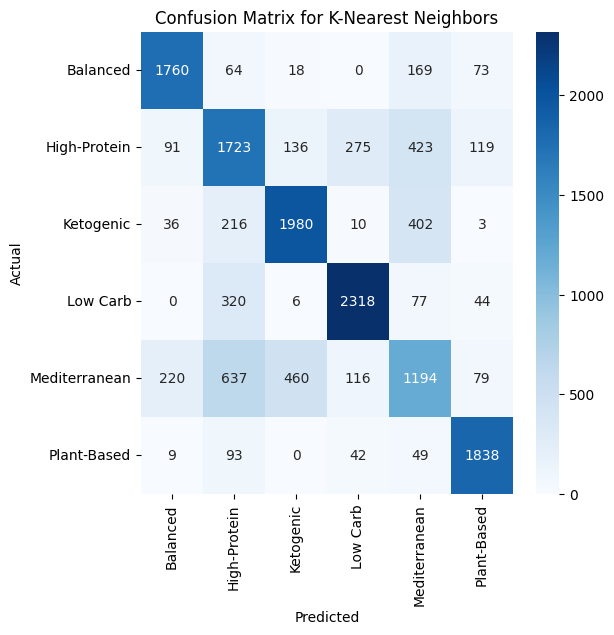

In [266]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier



# Define models and their parameter grids
models = {
    "Logistic Regression": {
        "model": LogisticRegression(),
        "param_grid": {
            "C": [0.1, 1, 10],
            "solver": ["liblinear", "lbfgs"]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(),
        "param_grid": {
            "n_estimators": [100, 200],
            "max_depth": [10, 20, None],
            "min_samples_split": [2, 5, 10]
        }
    },
    "Support Vector Classifier": {
        "model": SVC(),
        "param_grid": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf"]
        }
    },
    "K-Nearest Neighbors": {
        "model": KNeighborsClassifier(),
        "param_grid": {
            "n_neighbors": [3, 5, 7, 9],
            "weights": ["uniform", "distance"],
            "metric": ["euclidean", "manhattan"]
        }
    }
}

# Train, tune, and evaluate each model
for model_name, model_info in models.items():
    print(f"\nTraining {model_name}...")

    # Grid search for hyperparameter tuning
    grid_search = GridSearchCV(
        estimator=model_info["model"],
        param_grid=model_info["param_grid"],
        cv=3,
        n_jobs=-1,
        verbose=2
    )
    grid_search.fit(x_train, y_train)

    # Get the best model
    best_model = grid_search.best_estimator_

    # Predictions
    y_pred = best_model.predict(x_test)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Accuracy of {model_name}: {accuracy:.4f}")

    # Classification report
    print(f"Classification Report for {model_name}:\n{classification_report(y_test, y_pred)}")

    # Display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
